# RESNET ENCODER WITH SKIP CONNECTIONS
In this model we decided to keep resnet as transfer learning for the encoder part, and try to improve our performances by tuning hyperparameters, and then by implementing skip connections between encoder and decoder.

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
import numpy as np
import tensorflow as tf

# Set the seed for random operations
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  
cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Usual generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

#### Adaptation of the starting kit function to convert RGB masks to array or correspondant class/color

In [ ]:
from PIL import Image

def read_rgb_mask(img_path, resize_shape):

    mask_img = Image.open(img_path)
    mask_img = mask_img.resize(resize_shape, resample=Image.NEAREST)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))]  = 0    #orange, ex 216
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1    #white
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))]   = 2    #red

    return new_mask_arr

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.
  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[1024,1024]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
    mask = Image.open(os.path.join(self.dataset_dir, 'Annotations', curr_filename + '.png'))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    #0 1 2
    mask_arr = read_rgb_mask(os.path.join(self.dataset_dir, 'Annotations', curr_filename + '.png'),[1024,1024])

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    mask_arr[mask_arr == 255] = 0  #bg

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    # Add useful resnet image pre processing
    if self.preprocessing_function is not None:
       img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

#### Use 1024x1024 images not to lose to many informations

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input 

img_h = 1024
img_w = 1024

# Here we decided to train our model in all haricot images, to gather more data
dataset_dir = os.path.join('/content/drive/My Drive','haricot')

# We selected the resnet preprocessing function, very useful to get all subtle details
dataset = CustomDataset(dataset_dir, 'training', img_generator=img_data_gen, mask_generator=mask_data_gen, preprocessing_function=preprocess_input)

dataset_valid = CustomDataset(dataset_dir, 'validation', preprocessing_function=preprocess_input)

#### batcsh_size= 8 to limit overfitting

In [ ]:
bs = 8

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

#### Assign a color to each class

In [ ]:
# Let's test data generator
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

#### Plot some images next to their masks

[0. 1. 2.]


Text(0.5, 1.0, ' AUGMENTED IMAGE')

Text(0.5, 1.0, 'TARGET')

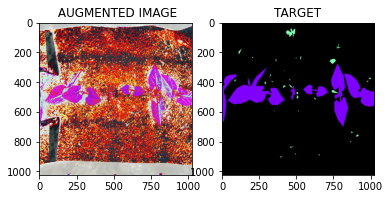

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

#default
target_img[np.where(target == 0)] = [0, 0, 0]

for i in range(1, 4):
    target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[0].set_title(" AUGMENTED IMAGE")
ax[1].imshow(np.uint8(target_img))
ax[1].set_title("TARGET")

plt.show()

### MODEL : Convolutional Neural Network (CNN)
RESNET: very useful as an encoder, it does something similar to the down sampling section of the U-Net

In [ ]:
# load model
resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3) )

# summarize the model
resnet.summary()
for layer in resnet.layers:
    layer.trainable = False

94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1030, 1030, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 512, 512, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 512, 512, 64) 256         conv1_conv[0][0]                 
__________________________

## SKIP CONNECTIONS

Extract from the tranfer learning resnet model the outputs of the activation layers

In [ ]:
maps = []

#maps.append(resnet.get_layer("conv5_block3_out").output)
maps.append(resnet.get_layer("conv4_block6_2_relu").output)
maps.append(resnet.get_layer("conv3_block4_2_relu").output)
maps.append(resnet.get_layer("conv2_block2_2_relu").output)

### Encoder-Decoder (Functional)

In [ ]:
def create_model(num_classes):

    start_f = 1024

    # Encoder
    
    inputs = resnet.output

    # Decoder

    x = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(inputs)                                  # 64 64 2048
    x = tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)     # 64 64 1024
    start_f = start_f // 2
    x = tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)     # 64 64 512
    start_f = start_f // 2
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)     # 64 64 256
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    start_f = start_f // 2

    # Here we add the output of the layers collected before with the relu output
    x = tf.keras.layers.Add()([x, maps[0]])

    x = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(x)
    x = tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    start_f = start_f // 2

    # Here we add the output of the layers collected before with the relu output
    x = tf.keras.layers.Add()([x, maps[1]])

    x = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(x)
    x = tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    start_f = start_f // 2

    # Here we add the output of the layers collected before with the relu output
    x = tf.keras.layers.Add()([x, maps[2]])

    x = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(x)
    x = tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    start_f = start_f // 2

    x = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(x)
    x = tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    start_f = start_f // 2

    # Prediction Layer
    convolutional = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='softmax')(x)

    # Final funcional model
    model = tf.keras.Model(inputs=resnet.input, outputs=convolutional)

    return model

#### Create model and visualize summary

In [ ]:
model = create_model(num_classes=3)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1030, 1030, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 512, 512, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 512, 512, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

#### Optimization params: prepare the model for training

In [ ]:
# Loss: Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 

# Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
  
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
        # Get prediction and target related to only a single class (i)
        class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
        class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
        intersection = tf.reduce_sum(class_true * class_pred)
        union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection

        iou = (intersection + 1e-7) / (union + 1e-7)
        per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
metrics = ['accuracy', meanIoU]

# Visualize initialized weights
# model.weights

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#### Training with callbacks

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)
    callbacks.append(es_callback)
    
bs = 8 

model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)/bs,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/bs, 
          callbacks=callbacks)

Epoch 1/100
81/81 [==============================] - 989s 12s/step - loss: 0.7770 - accuracy: 0.8049 - meanIoU: 0.2025 - val_loss: 1.3263 - val_accuracy: 0.3239 - val_meanIoU: 0.0768
Epoch 2/100
81/81 [==============================] - 676s 8s/step - loss: 0.4904 - accuracy: 0.9436 - meanIoU: 0.3424 - val_loss: 0.6309 - val_accuracy: 0.9047 - val_meanIoU: 0.3557
Epoch 3/100
81/81 [==============================] - 663s 8s/step - loss: 0.4119 - accuracy: 0.9533 - meanIoU: 0.3924 - val_loss: 0.4489 - val_accuracy: 0.9415 - val_meanIoU: 0.4449
Epoch 4/100
81/81 [==============================] - 661s 8s/step - loss: 0.3623 - accuracy: 0.9585 - meanIoU: 0.4241 - val_loss: 0.3752 - val_accuracy: 0.9539 - val_meanIoU: 0.4961
Epoch 5/100
81/81 [==============================] - 663s 8s/step - loss: 0.3258 - accuracy: 0.9619 - meanIoU: 0.4423 - val_loss: 0.3440 - val_accuracy: 0.9578 - val_meanIoU: 0.5206
Epoch 6/100
81/81 [==============================] - 662s 8s/step - loss: 0.2960 - accura

KeyboardInterrupt: ignored

### Compute prediction

In [ ]:
import time
import matplotlib.pyplot as plt

%matplotlib inline

iterator = iter(valid_dataset)

#### Plot some predicted masks

(1, 1024, 1024, 3)

Text(0.5, 1.0, 'IMAGE')

Text(0.5, 1.0, 'TARGET')

Text(0.5, 1.0, 'PREDICTION')

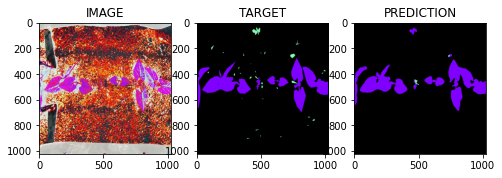

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 4):
    target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 4):
    prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[0].set_title("IMAGE")
ax[1].imshow(np.uint8(target_img))
ax[1].set_title("TARGET")
ax[2].imshow(np.uint8(prediction_img))
ax[2].set_title("PREDICTION")

fig.canvas.draw()
time.sleep(1)